Basic Statistics of the Data:
        magnitude         cdi         mmi     tsunami          sig  \
count  786.000000  786.000000  786.000000  786.000000   786.000000   
mean     6.939389    4.311705    5.951654    0.391858   869.092875   
std      0.445098    3.176874    1.469938    0.488476   321.959922   
min      6.500000    0.000000    1.000000    0.000000   650.000000   
25%      6.600000    0.000000    5.000000    0.000000   691.000000   
50%      6.800000    5.000000    6.000000    0.000000   754.000000   
75%      7.100000    7.000000    7.000000    1.000000   907.750000   
max      9.100000    9.000000    9.000000    1.000000  2910.000000   

            nst_x        dmin       gap_x       depth    latitude   longitude  \
count  786.000000  786.000000  786.000000  786.000000  786.000000  786.000000   
mean   229.320611    1.322258   25.735992   75.675142    3.787224   51.486974   
std    249.898668    2.214221   26.258217  136.957894   27.455917  118.641657   
min      0.0000

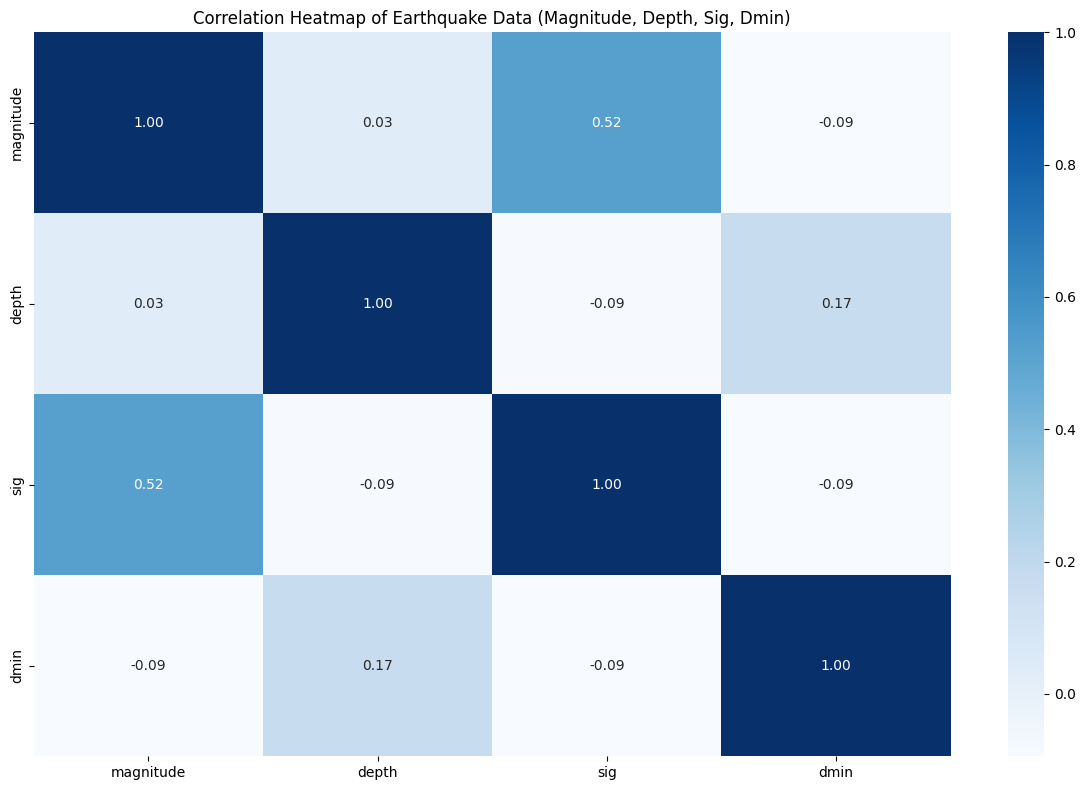

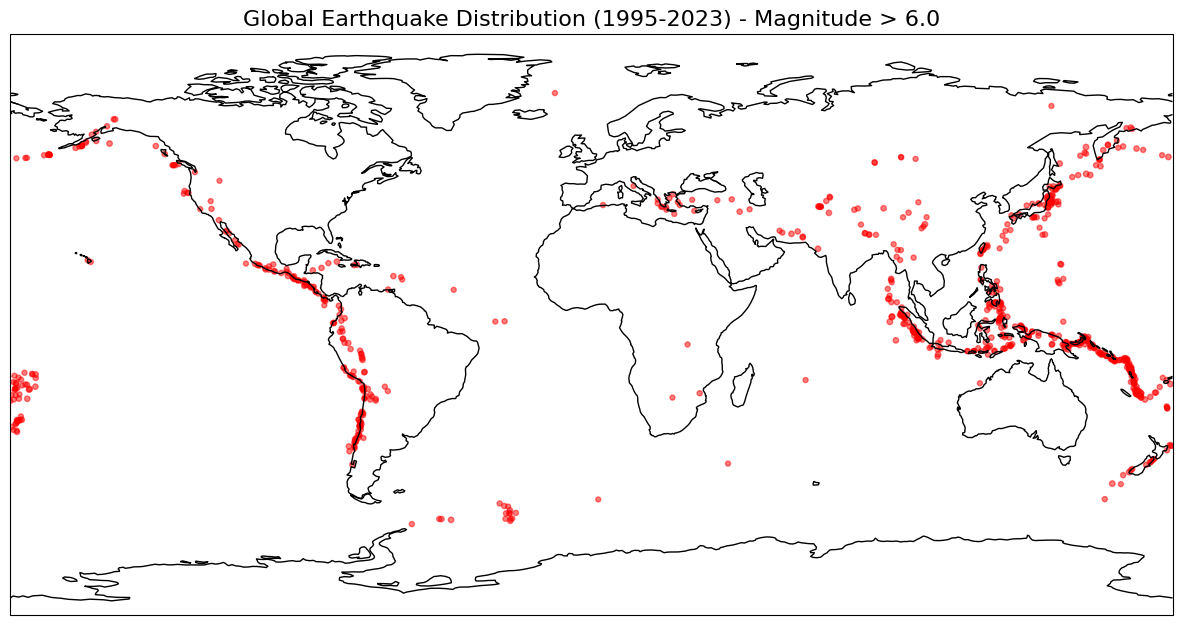

High-risk Zones (Magnitude > 6.0 & Tsunami Indicator = 1):
   latitude  longitude  magnitude  tsunami  cdi  mmi
0   -9.7963    159.596        7.0        1    8    7
2  -20.0508   -178.346        7.0        1    3    3
3  -19.2918   -172.129        7.3        1    5    5
4  -25.5948    178.278        6.6        1    0    2
5  -26.0442    178.381        7.0        1    4    3
CDI Prediction Performance:
MAE: 1.1618, MSE: 2.4446, R2: 0.7428


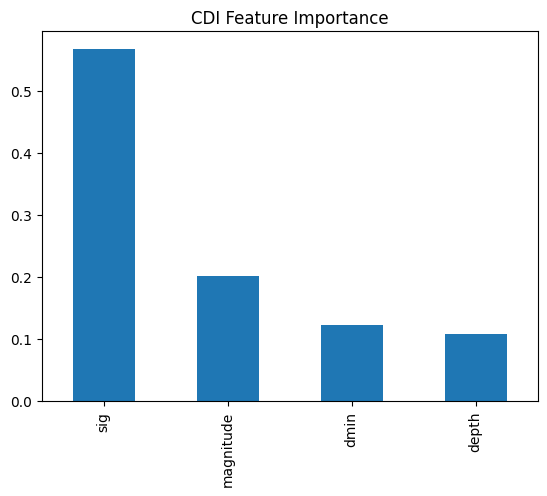


MMI Prediction Performance:
MAE: 0.8785, MSE: 1.2772, R2: 0.3106


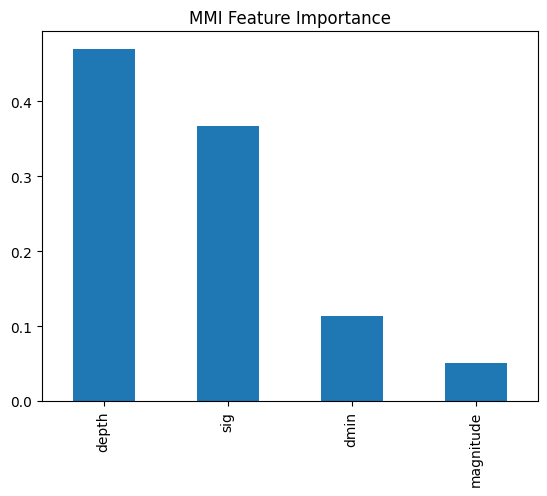

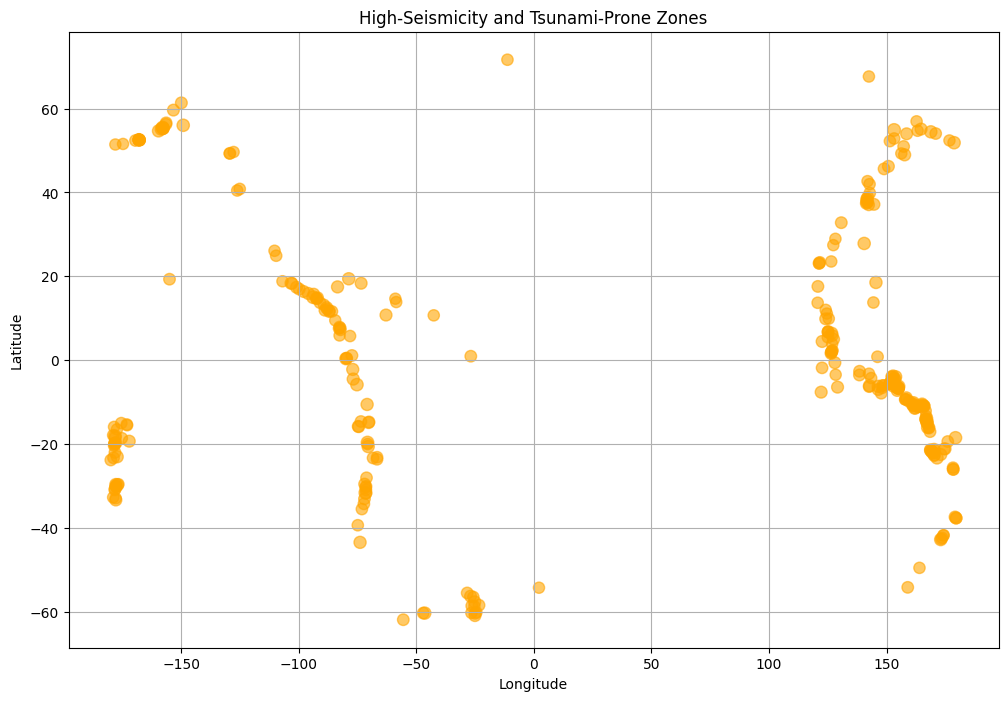

Summary of Key Insights:
Total high-risk events: 308
Top high-risk events:
     latitude  longitude  magnitude  tsunami
289  -31.5729   -71.6744        8.3        1
397   54.8920   153.2210        8.3        1
63    55.4742  -157.9170        8.2        1
64    55.3154  -157.8290        8.2        1
174  -18.1125  -178.1530        8.2        1


In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.crs as ccrs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the datasets
file_path_1 = "earthquake_1995-2023.csv"  # Replace with your correct file path
file_path_2 = "earthquake_data.csv"  # Replace with your correct file path

# Try to load the datasets and handle errors if they are not found
try:
    earthquake_data_1 = pd.read_csv(file_path_1)
    earthquake_data_2 = pd.read_csv(file_path_2)
except FileNotFoundError:
    print(f"Error: One or both of the datasets {file_path_1} or {file_path_2} were not found.")
    exit()

# Ensure columns are stripped of whitespace for consistency
earthquake_data_1.columns = earthquake_data_1.columns.str.strip()
earthquake_data_2.columns = earthquake_data_2.columns.str.strip()

# Merge the datasets on common columns (latitude, longitude, magnitude)
merged_data = pd.merge(
    earthquake_data_1,
    earthquake_data_2,
    how="inner",
    on=["latitude", "longitude", "magnitude"]
)

# Standardize column names to lowercase for consistency
merged_data.columns = merged_data.columns.str.strip().str.lower()

# Rename columns to avoid confusion due to suffixes
merged_data.rename(
    columns={
        "depth_x": "depth",
        "sig_x": "sig",
        "dmin_x": "dmin",
        "cdi_x": "cdi",
        "mmi_x": "mmi",
        "tsunami_x": "tsunami"
    },
    inplace=True
)

# Drop rows with missing values in critical numeric columns (magnitude, depth, sig, dmin)
numeric_columns = ["magnitude", "depth", "sig", "dmin"]
merged_data = merged_data.dropna(subset=numeric_columns)

# Exploratory Data Analysis (EDA): Print basic statistics of the data
print("Basic Statistics of the Data:")
print(merged_data.describe())

# Plot Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_data[numeric_columns].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap of Earthquake Data (Magnitude, Depth, Sig, Dmin)")
plt.tight_layout()
plt.show()

# Visualize Earthquake Distribution on a World Map using Cartopy
gdf = gpd.GeoDataFrame(
    merged_data, 
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude)
)
plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
gdf.plot(ax=ax, markersize=merged_data["magnitude"] * 2, color="red", alpha=0.5)
plt.title("Global Earthquake Distribution (1995-2023) - Magnitude > 6.0", fontsize=16)
plt.show()

# Identify High-Risk Zones based on Magnitude > 6.0 and Tsunami Indicator
high_risk_zones = merged_data[(merged_data["magnitude"] > 6.0) & (merged_data["tsunami"] == 1)]
print(f"High-risk Zones (Magnitude > 6.0 & Tsunami Indicator = 1):")
print(high_risk_zones[['latitude', 'longitude', 'magnitude', 'tsunami', 'cdi', 'mmi']].head())

# Time-based trend visualization (if time column exists)
if 'time' in merged_data.columns:
    merged_data['date'] = pd.to_datetime(merged_data['time'])
    merged_data['year'] = merged_data['date'].dt.year
    trend_data = merged_data.groupby('year')['magnitude'].mean()
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data.index, trend_data.values, marker='o')
    plt.title('Average Earthquake Magnitude Over Time (1995-2023)')
    plt.xlabel('Year')
    plt.ylabel('Average Magnitude')
    plt.grid()
    plt.show()

# Prepare data for predictive modeling (CDI and MMI)
features = ["magnitude", "depth", "sig", "dmin"]
target_cdi = "cdi"
target_mmi = "mmi"

# Drop rows with missing target values for CDI and MMI (important for model training)
merged_data = merged_data.dropna(subset=[target_cdi, target_mmi])

X = merged_data[features]
y_cdi = merged_data[target_cdi]
y_mmi = merged_data[target_mmi]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train_cdi, y_test_cdi = train_test_split(X, y_cdi, test_size=0.2, random_state=42)
X_train_mmi, X_test_mmi, y_train_mmi, y_test_mmi = train_test_split(X, y_mmi, test_size=0.2, random_state=42)

# Hyperparameter tuning for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# CDI Model
cdi_rf = RandomForestRegressor(random_state=42)
cdi_grid_search = GridSearchCV(cdi_rf, param_grid, cv=3, scoring='neg_mean_absolute_error')
cdi_grid_search.fit(X_train, y_train_cdi)
model_cdi = cdi_grid_search.best_estimator_

# Evaluate CDI Model
predictions_cdi = model_cdi.predict(X_test)
mae_cdi = mean_absolute_error(y_test_cdi, predictions_cdi)
mse_cdi = mean_squared_error(y_test_cdi, predictions_cdi)
r2_cdi = r2_score(y_test_cdi, predictions_cdi)
print(f"CDI Prediction Performance:\nMAE: {mae_cdi:.4f}, MSE: {mse_cdi:.4f}, R2: {r2_cdi:.4f}")

# Feature importance for CDI
feature_importance_cdi = pd.Series(model_cdi.feature_importances_, index=features)
feature_importance_cdi.sort_values(ascending=False).plot(kind='bar', title='CDI Feature Importance')
plt.show()

# MMI Model
mmi_rf = RandomForestRegressor(random_state=42)
mmi_grid_search = GridSearchCV(mmi_rf, param_grid, cv=3, scoring='neg_mean_absolute_error')
mmi_grid_search.fit(X_train_mmi, y_train_mmi)
model_mmi = mmi_grid_search.best_estimator_

# Evaluate MMI Model
predictions_mmi = model_mmi.predict(X_test_mmi)
mae_mmi = mean_absolute_error(y_test_mmi, predictions_mmi)
mse_mmi = mean_squared_error(y_test_mmi, predictions_mmi)
r2_mmi = r2_score(y_test_mmi, predictions_mmi)
print(f"\nMMI Prediction Performance:\nMAE: {mae_mmi:.4f}, MSE: {mse_mmi:.4f}, R2: {r2_mmi:.4f}")

# Feature importance for MMI
feature_importance_mmi = pd.Series(model_mmi.feature_importances_, index=features)
feature_importance_mmi.sort_values(ascending=False).plot(kind='bar', title='MMI Feature Importance')
plt.show()

# Geospatial Risk Maps: High-seismicity and tsunami-prone zones
plt.figure(figsize=(12, 8))
plt.scatter(high_risk_zones['longitude'], high_risk_zones['latitude'], s=high_risk_zones['magnitude'] * 10, alpha=0.6, color='orange')
plt.title('High-Seismicity and Tsunami-Prone Zones')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

# Dashboard-ready insights
print("Summary of Key Insights:")
print(f"Total high-risk events: {len(high_risk_zones)}")
print("Top high-risk events:")
print(high_risk_zones.nlargest(5, 'magnitude')[['latitude', 'longitude', 'magnitude', 'tsunami']])

In [10]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and preprocess datasets
file_path_1 = "earthquake_1995-2023.csv"
file_path_2 = "earthquake_data.csv"

try:
    earthquake_data_1 = pd.read_csv(file_path_1)
    earthquake_data_2 = pd.read_csv(file_path_2)
except FileNotFoundError:
    raise Exception("One or both datasets are not found. Please check file paths.")

earthquake_data_1.columns = earthquake_data_1.columns.str.strip()
earthquake_data_2.columns = earthquake_data_2.columns.str.strip()

merged_data = pd.merge(
    earthquake_data_1,
    earthquake_data_2,
    how="inner",
    on=["latitude", "longitude", "magnitude"]
)

merged_data.columns = merged_data.columns.str.lower()
merged_data.rename(
    columns={
        "depth_x": "depth",
        "sig_x": "sig",
        "dmin_x": "dmin",
        "cdi_x": "cdi",
        "mmi_x": "mmi",
        "tsunami_x": "tsunami"
    },
    inplace=True
)
numeric_columns = ["magnitude", "depth", "sig", "dmin"]
merged_data = merged_data.dropna(subset=numeric_columns)

# High-risk zones
high_risk_zones = merged_data[(merged_data["magnitude"] > 6.0) & (merged_data["tsunami"] == 1)]

# App layout
app = dash.Dash(__name__, external_stylesheets=["https://cdn.jsdelivr.net/npm/bootstrap@5.3.0-alpha1/dist/css/bootstrap.min.css"])

app.layout = html.Div([
    html.H1("Earthquake Analysis Dashboard", style={"text-align": "center"}),

    dcc.Tabs([
        dcc.Tab(label="Global Map", children=[
            dcc.Graph(
                id="global-map",
                figure=px.scatter_geo(
                    merged_data,
                    lat="latitude",
                    lon="longitude",
                    size="magnitude",
                    color="magnitude",
                    projection="natural earth",
                    title="Global Earthquake Distribution (1995-2023)"
                )
            )
        ]),
        dcc.Tab(label="High-Risk Zones", children=[
            dcc.Graph(
                id="high-risk-map",
                figure=px.scatter(
                    high_risk_zones,
                    x="longitude",
                    y="latitude",
                    size="magnitude",
                    color="magnitude",
                    hover_data=["latitude", "longitude", "magnitude", "tsunami"],
                    title="High-Seismicity and Tsunami-Prone Zones"
                )
            )
        ]),
        dcc.Tab(label="Correlation Analysis", children=[
            dcc.Graph(
                id="correlation-heatmap",
                figure=px.imshow(
                    merged_data[numeric_columns].corr(),
                    text_auto=True,
                    title="Correlation Heatmap of Earthquake Metrics"
                )
            )
        ]),
        dcc.Tab(label="Predictive Modeling", children=[
            html.Div([
                html.H4("CDI Prediction Performance:"),
                html.Div(id="cdi-performance", style={"margin-bottom": "20px"}),
                html.H4("MMI Prediction Performance:"),
                html.Div(id="mmi-performance")
            ])
        ]),
    ])
])

# Callbacks (if needed for interactivity)


if __name__ == '__main__':
    app.run_server(debug=True)
